In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your CPI data into a pandas DataFrame
# Assuming you have a CSV file with two columns: 'Date' and 'CPI'
data = pd.read_csv('cpi_data.csv')

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %y')

# Sort by date
data.sort_values(by='Date', inplace=True)

# Set 'Date' column as index
data.set_index('Date', inplace=True)

# You may need to preprocess your data further, such as handling missing values, smoothing, etc.

# Feature engineering: creating lag features if needed
# For example, if you want to use the CPI of the previous month as a feature
data['CPI_Lag1'] = data['CPI'].shift(1)

# Drop rows with NaN values (due to creating lag features)
data.dropna(inplace=True)

# Split data into train and test sets
X = data[['CPI_Lag1']]  # Features
y = data['CPI']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.title('CPI Prediction')
plt.xlabel('Previous CPI')
plt.ylabel('CPI')
plt.show()


In [43]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm

In [55]:
file_name = "J1newdata.xlsx"
data = pd.read_excel(file_name)
data.head()


,MONTH,AVERAGE
0,2023-23-1,112.18
1,2023-23-2,112.68
2,2023-23-3,112.68
3,2023-23-4,112.54
4,2023-23-5,112.51


In [44]:
#Splitiing the data

train_len = int(data.shape[0] * 0.8)
train_data, test_data = data[:train_len], data[train_len:]
y_train = train_data['AVERAGE'].values
y_test = test_data['AVERAGE'].values


print(f"{train_len} train samples")
print(f"{data.shape[0] - train_len} test samples")


9 train samples
3 test samples


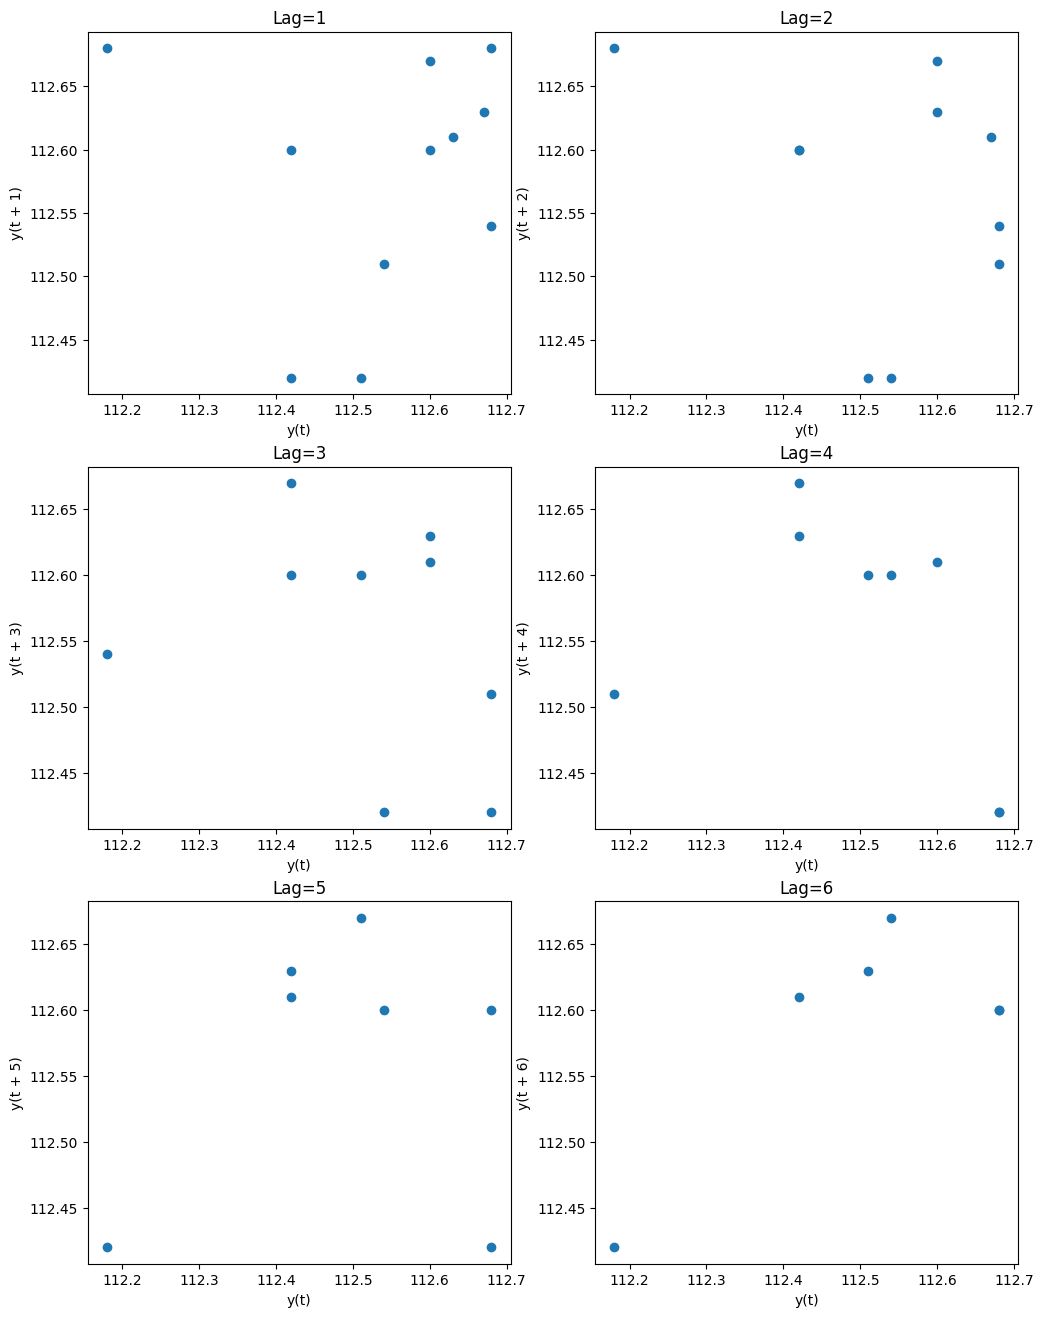

In [56]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('ANALYSIS')
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(data['AVERAGE'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

PRE MODELLING ANALYSIS

In [57]:
from pmdarima.arima import ndiffs

#Estimate order of differencing using KPSS test
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)

# Estimate order of differencing using ADF test
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=3)


# Get the maximum order of differencing estimated by either test
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 3


c:\Users\Aditya Dwaraki Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


USING AUTO ARIMA TO FIT A MODEL ON THE NEW DATA


In [58]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=5.233, Time=0.08 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2.490, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=4.489, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=3.835, Time=0.03 sec
 ARIMA(0,3,0)(0,0,0)[0] intercept   : AIC=4.215, Time=0.00 sec

Best model:  ARIMA(0,3,0)(0,0,0)[0]          
Total fit time: 0.133 seconds


In [59]:
print(auto.order)

(0, 3, 0)


In [60]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=30, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 0.037266666706176864
SMAPE: 0.16577681430568733


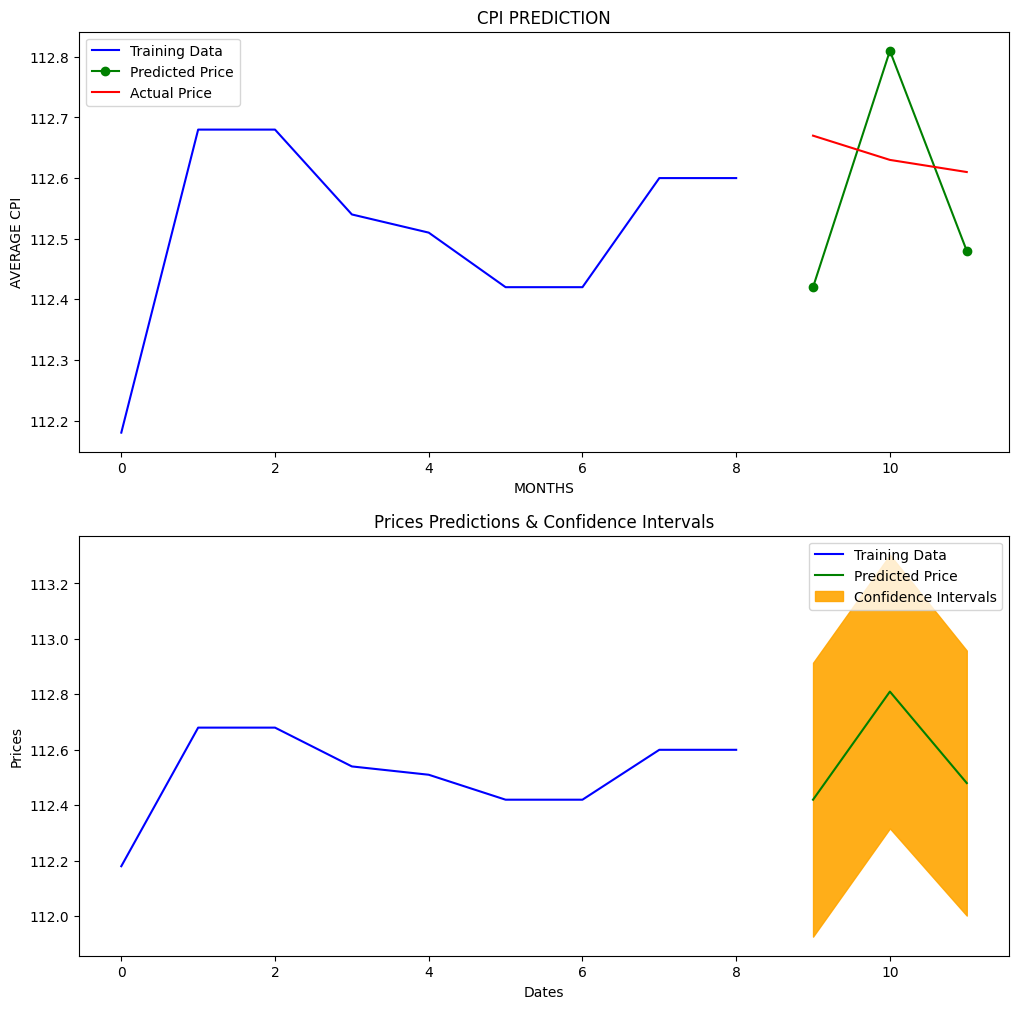

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('CPI PREDICTION')
axes[0].set_xlabel('MONTHS')
axes[0].set_ylabel('AVERAGE CPI')

#axes[0].set_xticks(data['MONTH'][0:7982:2500].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), data['MONTH'][0:7982:1300].tolist())
axes[1].legend()

In [53]:
data["MONTH"]

0       JANUARY
1      FEBRUARY
2         MARCH
3         APRIL
4           MAY
5          JUNE
6          JULY
7        AUGUST
8     SEPTEMBER
9       OCTOBER
10     NOVEMBER
11     DECEMBER
Name: MONTH, dtype: object